In [1]:
import torch
import gc

def deep_clean_cuda():
    if torch.cuda.is_available():
        print(f"Current VRAM Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    
        torch.cuda.synchronize()
        gc.collect()
        gc.collect()
        torch.cuda.empty_cache()
        
        print(f"Deep clean complete. Current VRAM Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

deep_clean_cuda()

Current VRAM Allocated: 0.00 MB
Deep clean complete. Current VRAM Allocated: 0.00 MB


### Generate using diffusion model

In [2]:
# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

/home/shay-lavi/miniconda3/envs/proj/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /home/shay-lavi/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-base/snapshots/f5bc1bd97485577aa0b946fa8a9004e2ec147402/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [6]:
prompt = "a funny meme"
image = pipe(prompt).images[0]  

image.save(f'generations/{prompt.replace(" ", "_")}.png')

  0%|          | 0/50 [00:00<?, ?it/s]

### RePaint

In [ ]:
import torch
import requests
from io import BytesIO
from PIL import Image, ImageOps, ImageDraw

from VanillaPipeline import VanillaPipeline
from diffusers import DDPMScheduler

model_id = "sd2-community/stable-diffusion-2-base"

scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = VanillaPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


/home/shay-lavi/miniconda3/envs/proj/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /home/shay-lavi/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-base/snapshots/f5bc1bd97485577aa0b946fa8a9004e2ec147402/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
# 3. Load an Input Image
init_image = Image.open("cat.jpg")

# 4. Create a Mask
# Here we create a simple white box in the middle to "repaint"
# Remember: 1.0 (white) = KEEP original, 0.0 (black) = REPAINT
mask = Image.new("L", (512, 512), 255) # Start with all 'keep'
draw = ImageDraw.Draw(mask)
draw.rectangle([150, 150, 350, 350], fill=0) # Area to repaint is 0 (black)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, clear_output  # for Jupyter

def decode_latents(pipeline, latents):
    """Decode latents to a PIL image for display."""
    latents = latents / pipeline.vae.config.scaling_factor
    with torch.no_grad():
        image = pipeline.vae.decode(latents, return_dict=False)[0]
    # [-1, 1] → [0, 1] → [0, 255]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    image = (image[0] * 255).astype(np.uint8)
    return Image.fromarray(image)

def make_callback(pipeline, display_every_n_steps=1):
    """
    Returns a callback function to pass into pipeline.__call__.
    
    display_every_n_steps: decode and show image every N steps (decoding is slow,
                           so you may want every 5 steps rather than every 1).
    """
    def callback(step: int, timestep: int, latents: torch.FloatTensor):
        if step % display_every_n_steps != 0:
            return
        
        img = decode_latents(pipeline, latents)
        
        # --- Jupyter ---
        clear_output(wait=True)
        display(img)
        print(f"Step {step} | timestep {timestep}")
        
        # --- Matplotlib (works outside Jupyter too) ---
        axes.clear()
        axes.imshow(img)
        axes.set_title(f"Step {step} / timestep {timestep}")
        axes.axis("off")
        plt.pause(0.01)

    return callback

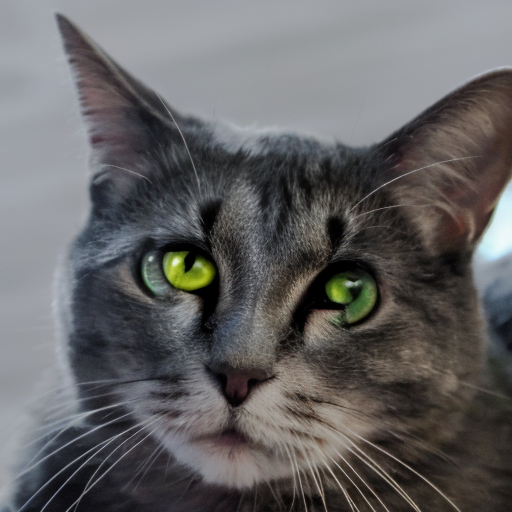

Step 49 | timestep 1


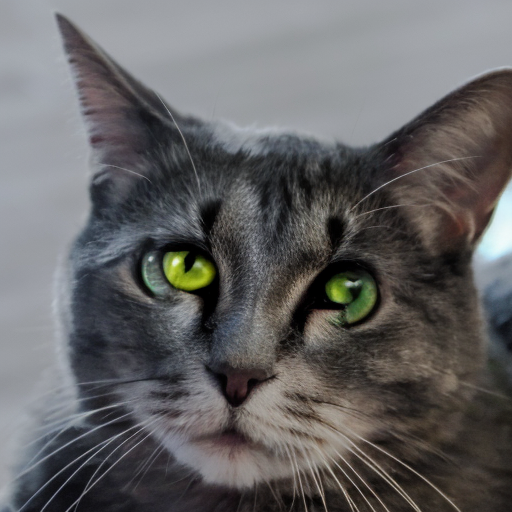

In [36]:
# 5. Run the Pipeline
prompt = "a photo of a grey cat with red eyes"

# --- Setup display ---
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.ion()  # interactive mode on

# RePaint parameters (T=250, U=10 is standard for the paper)
output = pipe(
    prompt=prompt,
    num_inference_steps=50,
    image=init_image,
    mask=mask,
    guidance_scale=7.5,
    callback=make_callback(pipe, display_every_n_steps=1),  # decode every 5 steps
    callback_steps=1,   # call the callback at every step (filtering happens inside)
)

plt.ioff()
# 6. Save and Show
final_image = output.images[0]
final_image.show()
